# PhysioNet 2012 ICU Dataset — Exploratory Data Analysis

This notebook inspects the PhysioNet 2012 Challenge data included in this repository. It focuses on demographic descriptors, feature availability, and example time-series behavior to build intuition for subsequent modeling work.


## Setup
Import helper utilities and configure plotting defaults. The notebook reuses the data loading utilities from `dataloader.py` to stay consistent with the rest of the project.


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataloader import (
    load_raw_dataset,
    TIME_SERIES_VARIABLES,
    compute_feature_missingness,
    pivot_timeseries,
)

sns.set_theme(style="whitegrid")


## Load general descriptors and time series
Set paths relative to the repo root and load `set-a`, which includes the labeled training cohort used for model development.


In [2]:
DATA_DIR = Path("data")
SET_NAME = "set-a"

general_info_df, timeseries_dict = load_raw_dataset(DATA_DIR, SET_NAME, verbose=False)
print(f"Loaded {len(general_info_df)} patients from {SET_NAME} and {len(timeseries_dict)} time-series files.")
general_info_df.head()


Loaded 4000 patients from set-a and 4000 time-series files.


,RecordID,Age,Gender,Height,ICUType,Weight
0,132539.0,54.0,0.0,-1.0,4.0,-1.0
1,132540.0,76.0,1.0,175.3,2.0,76.0
2,132541.0,44.0,0.0,-1.0,3.0,56.7
3,132543.0,68.0,1.0,180.3,3.0,84.6
4,132545.0,88.0,0.0,-1.0,3.0,-1.0


## Demographic descriptors
Look at the basic descriptors that are recorded for each ICU stay. The dataset encodes gender as 0=female, 1=male and ICUType as integer categories (1=Coronary Care, 2=Cardiac Surgery Recovery, 3=Medical ICU, 4=Surgical ICU).


In [3]:
descriptor_cols = ["Age", "Gender", "Height", "ICUType", "Weight"]

demographic_summary = general_info_df[descriptor_cols].apply(pd.to_numeric, errors="coerce")
demographic_summary.describe(percentiles=[0.25, 0.5, 0.75])


,Age,Gender,Height,ICUType,Weight
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000
mean,64.247500,0.560750,88.919475,2.760000,74.75629
std,17.560946,0.497867,86.531203,1.002572,31.97107
min,15.000000,-1.000000,-1.000000,1.000000,-1.00000
25%,52.750000,0.000000,-1.000000,2.000000,62.00000
50%,67.000000,1.000000,152.400000,3.000000,76.20000
75%,78.000000,1.000000,170.200000,4.000000,90.42500
max,90.000000,1.000000,431.800000,4.000000,300.00000


/var/folders/s7/wf5nzk_95hn1kf22np4d8c0c0000gq/T/ipykernel_74513/395048972.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[1], palette="pastel")
/var/folders/s7/wf5nzk_95hn1kf22np4d8c0c0000gq/T/ipykernel_74513/395048972.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=icu_counts.index, y=icu_counts.values, ax=axes[2], palette="muted")


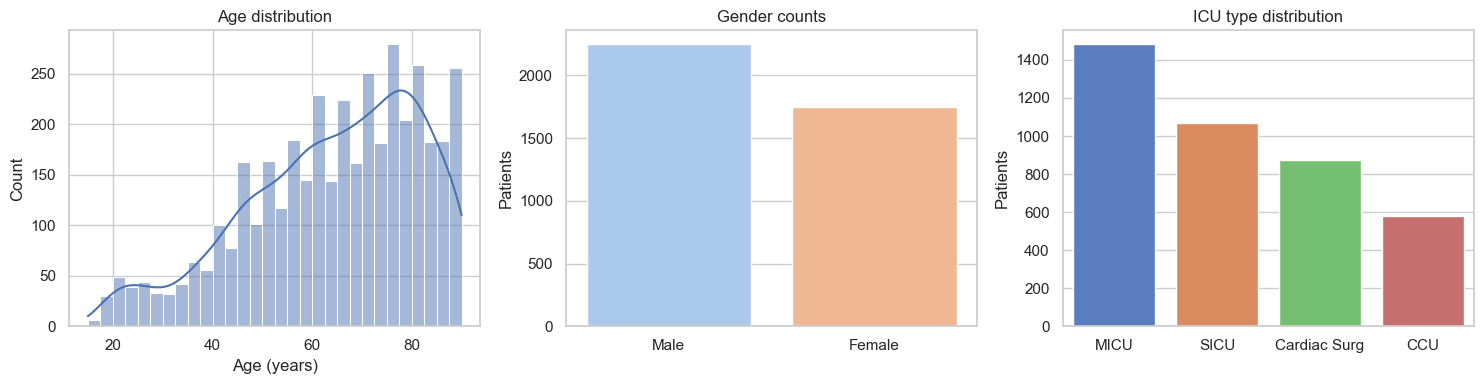

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

age_series = demographic_summary["Age"].dropna()
sns.histplot(age_series, bins=30, kde=True, ax=axes[0])
axes[0].set_title("Age distribution")
axes[0].set_xlabel("Age (years)")

# Gender counts (0=female, 1=male per challenge docs)
gender_counts = (
    demographic_summary["Gender"].map({0: "Female", 1: "Male"}).value_counts(dropna=True)
)
sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[1], palette="pastel")
axes[1].set_title("Gender counts")
axes[1].set_xlabel("")
axes[1].set_ylabel("Patients")

icu_map = {
    1: "CCU",
    2: "Cardiac Surg",
    3: "MICU",
    4: "SICU",
}
icu_counts = demographic_summary["ICUType"].map(icu_map).value_counts(dropna=True)
sns.barplot(x=icu_counts.index, y=icu_counts.values, ax=axes[2], palette="muted")
axes[2].set_title("ICU type distribution")
axes[2].set_xlabel("")
axes[2].set_ylabel("Patients")
plt.tight_layout()


## Measurement coverage per patient
Count how many charted measurements exist per admission and visualize the distribution to understand how sparse the records are.


count    4000.000000
mean      433.495000
std       129.046587
min         0.000000
25%       354.000000
50%       422.000000
75%       506.000000
max      1496.000000
dtype: float64

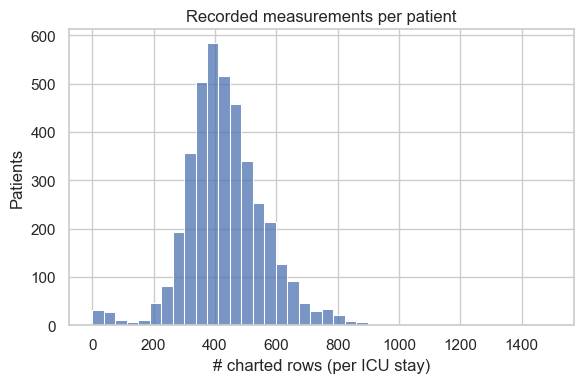

In [5]:
measurement_counts = pd.Series({pid: len(ts) for pid, ts in timeseries_dict.items()})

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(measurement_counts, bins=40, ax=ax)
ax.set_title("Recorded measurements per patient")
ax.set_xlabel("# charted rows (per ICU stay)")
ax.set_ylabel("Patients")
plt.tight_layout()

measurement_counts.describe(percentiles=[0.25, 0.5, 0.75])


## Feature availability / missingness
Use the helper in `dataloader.py` to compute missingness for every time-series variable. Sorting the results highlights which labs and vitals are best populated.


In [6]:
missingness = compute_feature_missingness(timeseries_dict, TIME_SERIES_VARIABLES)
missingness_df = (
    pd.Series(missingness, name="missing_rate")
    .sort_values()
    .to_frame()
)
missingness_df.head(10)


,missing_rate
HR,0.226223
SysABP,0.506863
DiasABP,0.507144
MAP,0.512802
Urine,0.541709
Weight,0.576220
NISysABP,0.667074
NIDiasABP,0.667484
NIMAP,0.672017
Temp,0.708140


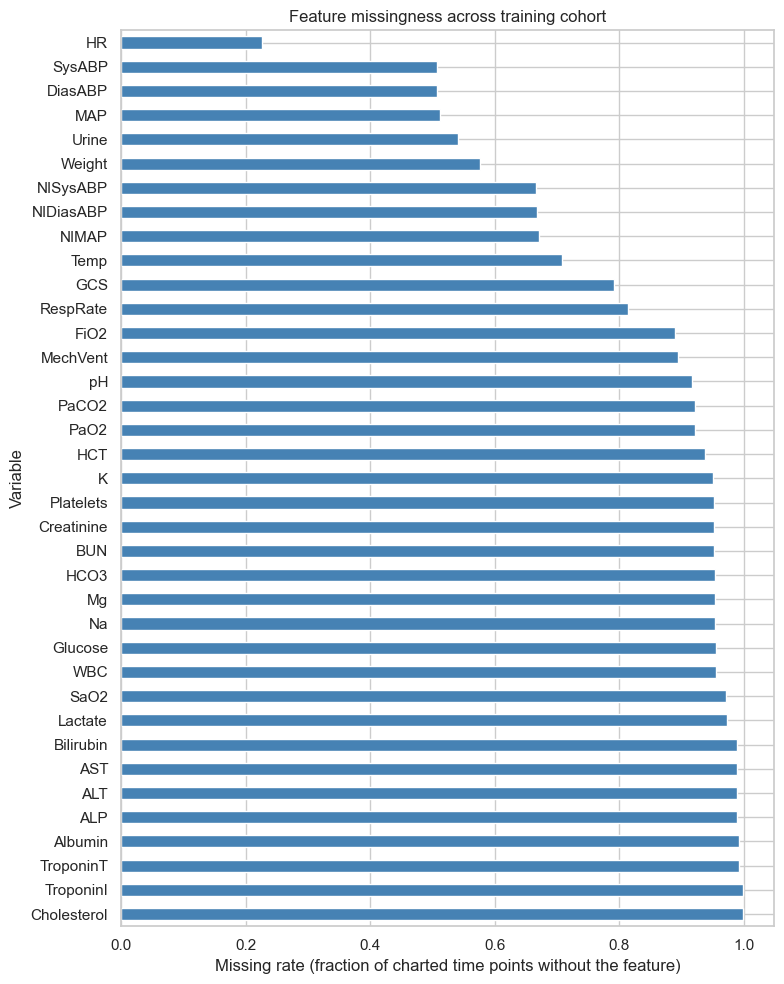

In [7]:
fig, ax = plt.subplots(figsize=(8, 10))
missingness_df[::-1].plot(kind="barh", legend=False, ax=ax, color="steelblue")
ax.set_xlabel("Missing rate (fraction of charted time points without the feature)")
ax.set_ylabel("Variable")
ax.set_title("Feature missingness across training cohort")
plt.tight_layout()


## Example patient trajectory
Sample a single patient trajectory and pivot it to wide format to inspect typical vital trends.


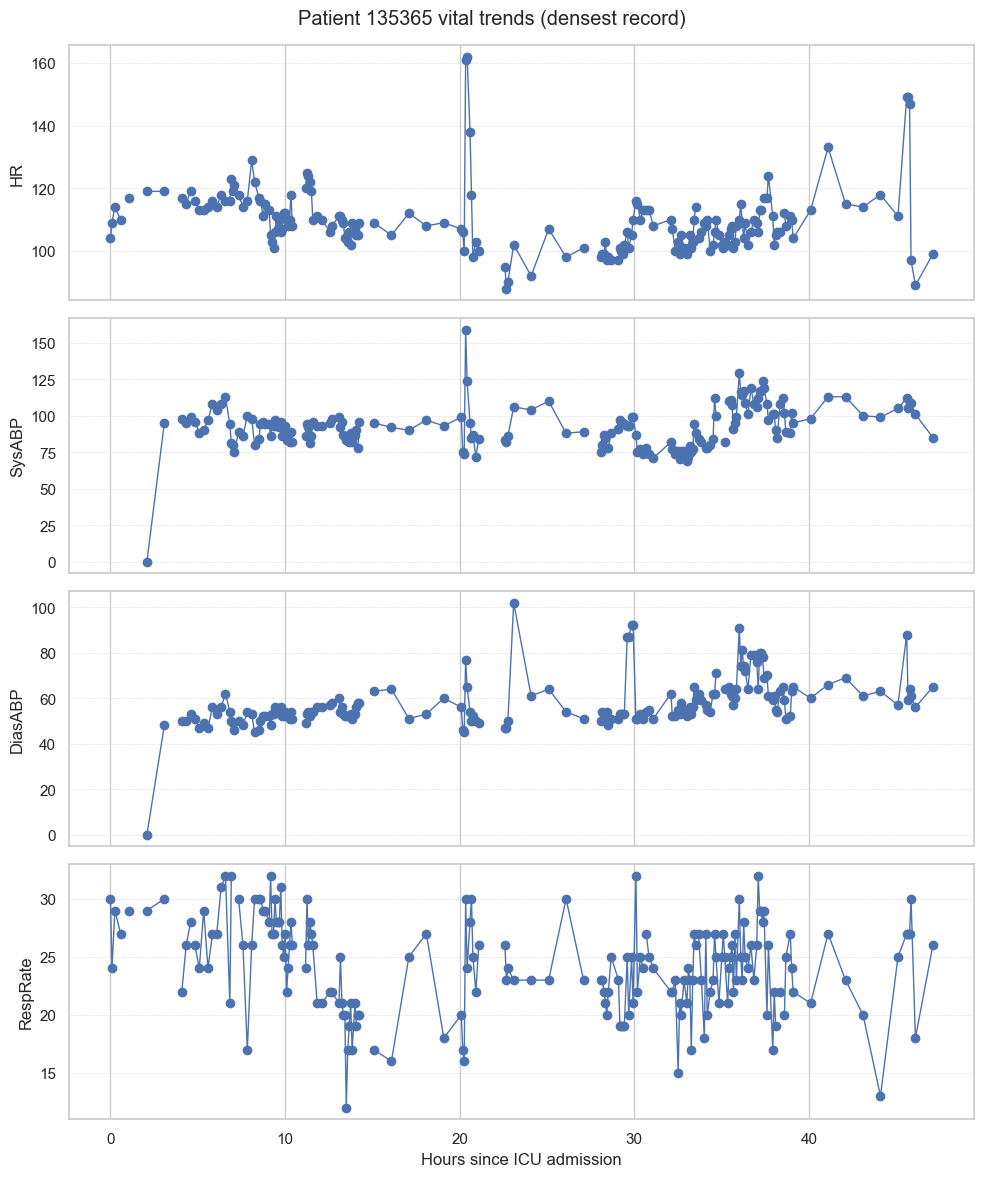

In [23]:
example_patient = measurement_counts.idxmax()
example_ts = pivot_timeseries(timeseries_dict[example_patient])
selected_vars = ["HR", "SysABP", "DiasABP", "RespRate"]

fig, axes = plt.subplots(len(selected_vars), 1, figsize=(10, 12), sharex=True)
for ax, var in zip(axes, selected_vars):
    if var in example_ts.columns:
        ax.plot(example_ts.index, example_ts[var], marker="o", linewidth=1)
        ax.set_ylabel(var)
    else:
        ax.text(0.5, 0.5, "Not recorded", ha="center", va="center")
        ax.set_ylabel(var)
    ax.grid(True, axis="y", linestyle=":", linewidth=0.5)
axes[-1].set_xlabel("Hours since ICU admission")
fig.suptitle(f"Patient {example_patient} vital trends (densest record)")
plt.tight_layout()
plt.subplots_adjust(top=0.95)

available_vars = [var for var in selected_vars if var in example_ts.columns]
if available_vars:
    example_ts[available_vars].head()
else:
    print("Selected variables are not present for this patient.")


## Next steps
- Fit quick baseline mortality models (e.g., logistic regression) using the horizon summaries to quantify signal.
- Explore SHAP/feature importances per ICU type to catch cohort-specific effects.
- Extend the pipeline to include `set-b` for external validation and stress-test the imputation strategy.


## Outcomes and mortality labels
Merge `Outcomes-a.txt` to attach SAPS-I / SOFA severity scores and mortality indicators to the demographic descriptors.


In [9]:
OUTCOMES_PATH = DATA_DIR / "Outcomes-a.txt"
outcomes_df = pd.read_csv(OUTCOMES_PATH)

# Ensure RecordID is numeric for consistent joins
general_info_df["RecordID"] = general_info_df["RecordID"].astype(int)
outcomes_df.head()


,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,6,1,5,-1,0
1,132540,16,8,8,-1,0
2,132541,21,11,19,-1,0
3,132543,7,1,9,575,0
4,132545,17,2,4,918,0


In [10]:
mortality_merged = (
    general_info_df.merge(
        outcomes_df,
        on="RecordID",
        how="inner",
        validate="one_to_one",
    )
    .assign(
        mortality_label=lambda d: d["In-hospital_death"].map({0: "Survivor", 1: "Non-survivor"})
    )
)

mortality_merged["measurement_count"] = mortality_merged["RecordID"].map(measurement_counts)

mortality_merged.filter(
    [
        "RecordID",
        "Age",
        "Gender",
        "ICUType",
        "SAPS-I",
        "SOFA",
        "Length_of_stay",
        "In-hospital_death",
        "mortality_label",
        "measurement_count",
    ]
).head()


,RecordID,Age,Gender,ICUType,SAPS-I,SOFA,Length_of_stay,In-hospital_death,mortality_label,measurement_count
0,132539,54.0,0.0,4.0,6,1,5,0,Survivor,267
1,132540,76.0,1.0,2.0,16,8,8,0,Survivor,522
2,132541,44.0,0.0,3.0,21,11,19,0,Survivor,428
3,132543,68.0,1.0,3.0,7,1,9,0,Survivor,428
4,132545,88.0,0.0,3.0,17,2,4,0,Survivor,318


## Survivors vs. non-survivors
Quantify class balance and contrast the severity descriptors / measurement coverage between outcome groups.


/var/folders/s7/wf5nzk_95hn1kf22np4d8c0c0000gq/T/ipykernel_74513/4140925738.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mortality_counts.index, y=mortality_counts.values, ax=ax, palette="Set2")


Outcome
Survivor        3446
Non-survivor     554
Name: count, dtype: int64

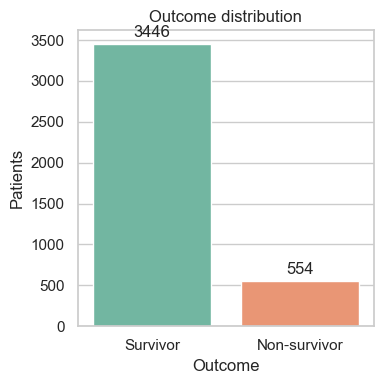

In [11]:
mortality_counts = mortality_merged["mortality_label"].value_counts().rename_axis("Outcome")
fig, ax = plt.subplots(figsize=(4, 4))
sns.barplot(x=mortality_counts.index, y=mortality_counts.values, ax=ax, palette="Set2")
ax.set_ylabel("Patients")
ax.set_title("Outcome distribution")
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=3)
plt.tight_layout()
mortality_counts


In [12]:
comparison_cols = ["Age", "SAPS-I", "SOFA", "Length_of_stay", "measurement_count"]

survival_summary = (
    mortality_merged.groupby("mortality_label")[comparison_cols]
    .agg(["mean", "median", "std"])
    .round(2)
)
survival_summary


Age               SAPS-I               SOFA               \
                  mean median    std   mean median   std  mean median   std   
mortality_label                                                               
Non-survivor     69.97   74.0  16.15  16.57   17.0  6.15  8.26    8.0  4.56   
Survivor         63.33   66.0  17.61  13.82   14.0  5.99  6.10    6.0  4.06   

                Length_of_stay               measurement_count                 
                          mean median    std              mean median     std  
mortality_label                                                                
Non-survivor             14.48   10.0  15.04            457.30  438.5  131.70  
Survivor                 13.28   10.0  11.73            429.67  420.0  128.22

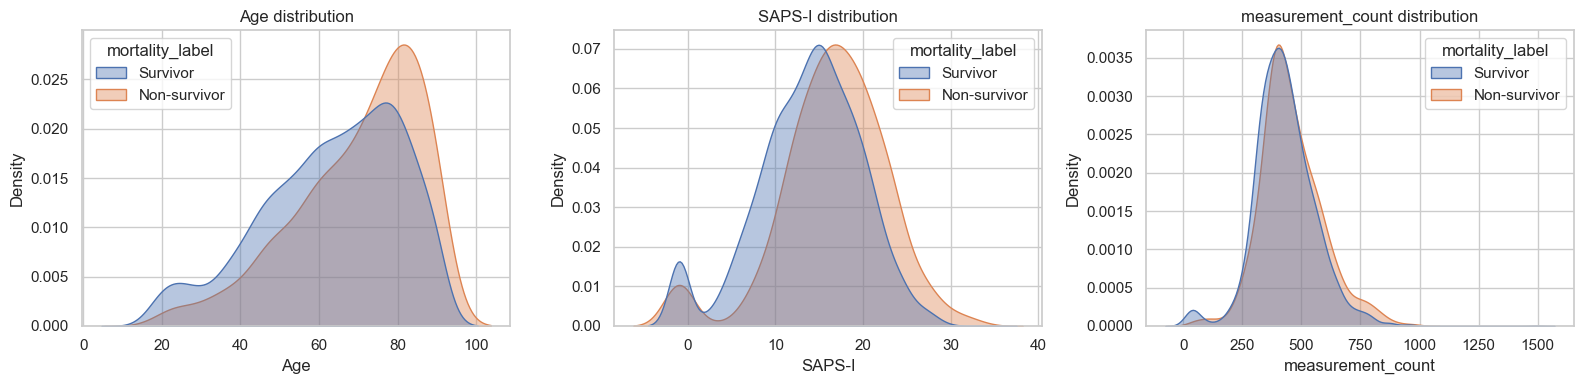

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_features = ["Age", "SAPS-I", "measurement_count"]

def plot_kde(ax, feature):
    sns.kdeplot(
        data=mortality_merged,
        x=feature,
        hue="mortality_label",
        fill=True,
        common_norm=False,
        alpha=0.4,
        ax=ax,
    )
    ax.set_title(f"{feature} distribution")
    ax.set_xlabel(feature)

for axis, feature in zip(axes, plot_features):
    plot_kde(axis, feature)

plt.tight_layout()


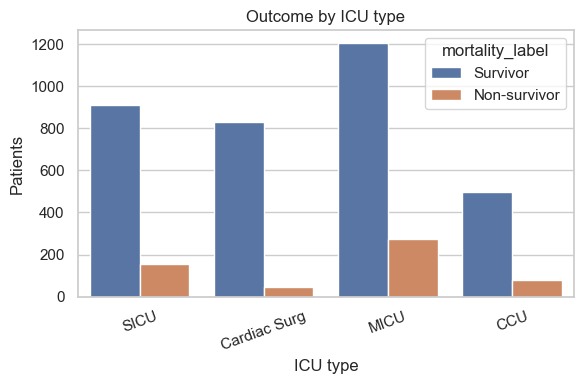

In [14]:
icu_map = {
    1: "CCU",
    2: "Cardiac Surg",
    3: "MICU",
    4: "SICU",
}

icu_df = mortality_merged.assign(ICUTypeLabel=mortality_merged["ICUType"].map(icu_map))
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(data=icu_df, x="ICUTypeLabel", hue="mortality_label", ax=ax)
ax.set_xlabel("ICU type")
ax.set_ylabel("Patients")
ax.set_title("Outcome by ICU type")
plt.xticks(rotation=20)
plt.tight_layout()


## Horizon-based summary statistics
Aggregate vital/lab time series over clinically meaningful windows (first 6h and 24h) to obtain fixed-length features suitable for downstream modeling.


In [22]:
HORIZONS = [6, 24]
SUMMARY_VARS = ["HR", "SysABP", "DiasABP", "MAP", "RespRate", "SaO2", "Temp", "WBC", "Creatinine", "Lactate"]


def summarize_patient_timeseries(ts: pd.DataFrame, horizons: list[int], variables: list[str]) -> dict:
    summary = {}
    if ts.empty:
        return summary

    ts = ts.copy()
    ts["value"] = pd.to_numeric(ts["value"], errors="coerce")

    for horizon in horizons:
        subset = ts[ts["time_hours"] <= horizon]
        if subset.empty:
            continue

        pivoted = pivot_timeseries(subset)
        for var in variables:
            if var not in pivoted.columns:
                continue
            series = pd.to_numeric(pivoted[var], errors="coerce")
            summary[f"{var}_mean_{horizon}h"] = series.mean()
            summary[f"{var}_std_{horizon}h"] = series.std()
            last_valid = series.dropna()
            summary[f"{var}_last_{horizon}h"] = last_valid.iloc[-1] if not last_valid.empty else np.nan
    return summary



In [16]:
summary_rows = []
for pid, ts in timeseries_dict.items():
    stats = summarize_patient_timeseries(ts, HORIZONS, SUMMARY_VARS)
    stats["RecordID"] = pid
    summary_rows.append(stats)

summary_feature_df = pd.DataFrame(summary_rows).set_index("RecordID")
summary_feature_df.head()


,HR_mean_6h,HR_std_6h,HR_last_6h,RespRate_mean_6h,RespRate_std_6h,RespRate_last_6h,Temp_mean_6h,Temp_std_6h,Temp_last_6h,HR_mean_24h,...,MAP_last_24h,SaO2_mean_24h,SaO2_std_24h,SaO2_last_24h,Lactate_mean_6h,Lactate_std_6h,Lactate_last_6h,Lactate_mean_24h,Lactate_std_24h,Lactate_last_24h
RecordID,,,,,,,,,,,,,,,,,,,,,
132539,71.285714,7.476949,73.0,18.857143,1.069045,17.0,36.166667,1.436431,37.8,66.541667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132540,88.000000,0.000000,88.0,NaN,NaN,NaN,35.525000,0.803543,37.2,84.404762,...,81.0,97.75,0.957427,97.0,NaN,NaN,NaN,NaN,NaN,NaN
132541,91.000000,9.394147,86.0,NaN,NaN,NaN,37.500000,0.424264,37.2,87.448276,...,NaN,95.00,NaN,95.0,1.3,NaN,1.3,1.6,0.424264,1.9
132543,77.647059,4.729445,72.0,16.800000,2.210365,15.0,36.350000,0.070711,36.4,72.971429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132545,88.000000,5.338539,82.0,22.600000,2.966479,19.0,36.800000,1.414214,35.8,79.520000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
summary_with_labels = mortality_merged.set_index("RecordID").join(summary_feature_df)

selected_summary_cols = [
    "HR_mean_6h",
    "HR_last_6h",
    "MAP_mean_24h",
    "SaO2_mean_24h",
    "Creatinine_mean_24h",
    "Lactate_mean_24h",
]

summary_with_labels.groupby("mortality_label")[selected_summary_cols].mean().round(2)


,HR_mean_6h,HR_last_6h,MAP_mean_24h,SaO2_mean_24h,Creatinine_mean_24h,Lactate_mean_24h
mortality_label,,,,,,
Non-survivor,90.93,89.57,80.38,95.99,1.77,3.18
Survivor,87.35,86.66,80.65,96.86,1.31,2.32


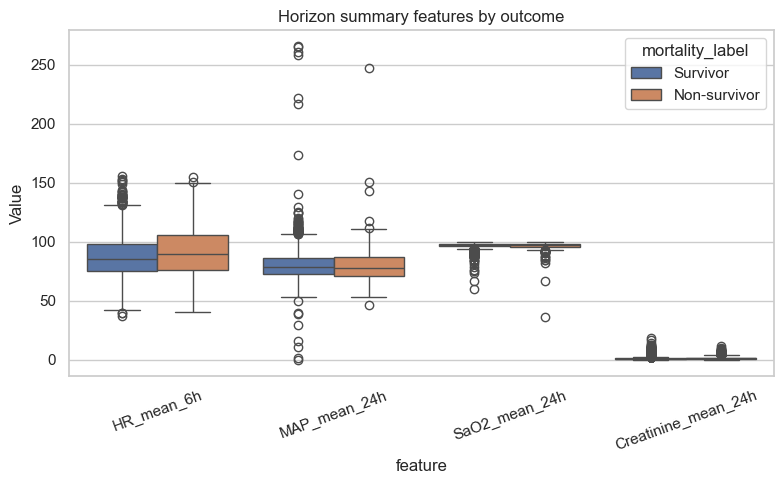

In [18]:
melt_cols = ["HR_mean_6h", "MAP_mean_24h", "SaO2_mean_24h", "Creatinine_mean_24h"]
plot_df = summary_with_labels.reset_index()[["mortality_label", *melt_cols]].melt(
    id_vars="mortality_label", var_name="feature", value_name="value"
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=plot_df, x="feature", y="value", hue="mortality_label", ax=ax)
plt.xticks(rotation=20)
ax.set_ylabel("Value")
ax.set_title("Horizon summary features by outcome")
plt.tight_layout()


## Missingness-aware imputation plan
Treat high-missing labs (e.g., troponins) differently from frequently collected vitals by using population-level medians plus missingness indicators for the former, and simple per-feature medians for the latter.


In [19]:
high_missing_features = missingness_df.query("missing_rate >= 0.8").index.tolist()
frequent_features = missingness_df.query("missing_rate < 0.4").index.tolist()


def infer_feature_name(summary_col: str) -> str:
    return summary_col.split("_")[0]


def impute_summary_features(summary_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    imputed = summary_df.copy()
    imputation_meta = []

    for col in summary_df.columns:
        feature = infer_feature_name(col)
        category = (
            "high_missing_lab"
            if feature in high_missing_features
            else ("frequent_vital" if feature in frequent_features else "mid_missing")
        )
        series = summary_df[col]
        missing_rate = series.isna().mean()
        if series.notna().sum() == 0:
            continue
        fill_value = series.median()
        imputed[col] = series.fillna(fill_value)
        if category == "high_missing_lab":
            imputed[f"{col}_was_missing"] = series.isna().astype(int)
        imputation_meta.append(
            {
                "feature_column": col,
                "base_feature": feature,
                "category": category,
                "missing_rate": missing_rate,
                "fill_value": round(fill_value, 3),
            }
        )
    return imputed, pd.DataFrame(imputation_meta)


imputed_summary_df, imputation_plan_df = impute_summary_features(summary_feature_df)
imputation_plan_df.head(10)


,feature_column,base_feature,category,missing_rate,fill_value
0,HR_mean_6h,HR,frequent_vital,0.03975,86.400
1,HR_std_6h,HR,frequent_vital,0.04675,5.339
2,HR_last_6h,HR,frequent_vital,0.03975,86.000
3,RespRate_mean_6h,RespRate,high_missing_lab,0.73075,19.000
4,RespRate_std_6h,RespRate,high_missing_lab,0.73525,2.828
5,RespRate_last_6h,RespRate,high_missing_lab,0.73075,19.000
6,Temp_mean_6h,Temp,mid_missing,0.05375,36.625
7,Temp_std_6h,Temp,mid_missing,0.30500,0.346
8,Temp_last_6h,Temp,mid_missing,0.05375,36.800
9,HR_mean_24h,HR,frequent_vital,0.01775,86.222


In [20]:
imputed_summary_df.head()


,HR_mean_6h,HR_std_6h,HR_last_6h,RespRate_mean_6h,RespRate_std_6h,RespRate_last_6h,Temp_mean_6h,Temp_std_6h,Temp_last_6h,HR_mean_24h,...,Creatinine_last_6h_was_missing,SaO2_mean_24h_was_missing,SaO2_std_24h_was_missing,SaO2_last_24h_was_missing,Lactate_mean_6h_was_missing,Lactate_std_6h_was_missing,Lactate_last_6h_was_missing,Lactate_mean_24h_was_missing,Lactate_std_24h_was_missing,Lactate_last_24h_was_missing
RecordID,,,,,,,,,,,,,,,,,,,,,
132539,71.285714,7.476949,73.0,18.857143,1.069045,17.0,36.166667,1.436431,37.8,66.541667,...,1,1,1,1,1,1,1,1,1,1
132540,88.000000,0.000000,88.0,19.000000,2.828427,19.0,35.525000,0.803543,37.2,84.404762,...,0,0,0,0,1,1,1,1,1,1
132541,91.000000,9.394147,86.0,19.000000,2.828427,19.0,37.500000,0.424264,37.2,87.448276,...,0,0,1,0,0,1,0,0,0,0
132543,77.647059,4.729445,72.0,16.800000,2.210365,15.0,36.350000,0.070711,36.4,72.971429,...,0,1,1,1,1,1,1,1,1,1
132545,88.000000,5.338539,82.0,22.600000,2.966479,19.0,36.800000,1.414214,35.8,79.520000,...,0,1,1,1,1,1,1,1,1,1
